In [ ]:
import pandas as pd
import tensorflow as tf

DATA_PATH = '/home/kshipra/work/major/ml experiments/data/manually_combined.xlsx'

eos = pd.read_excel(DATA_PATH, sheet_name='all_stacked_eos')
sentinel = pd.read_excel(DATA_PATH, sheet_name='all_stacked_sentinel')
combined = pd.read_excel(DATA_PATH, sheet_name='eos_sent_combined')

len(eos), len(sentinel), len(combined)

2025-09-10 18:38:35.907670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(747, 796, 747)

In [2]:
combined = combined[combined['SM (Combined)'] < 150]

X_cols = ['VH', 'VV', 'HH', 'HV', 'Angle']
y_col = ['SM (Combined)']

In [3]:
import pandas as pd
from model_experiments import PredictionIntervalEstimation
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
all_results = []

In [9]:
def fine_tune(param_grid, random_seed=42):
    all_results = []

    features = X_cols
    target = y_col[0]
    data = combined

    for idx, params in enumerate(param_grid):
        print(f"\n--- Testing Configuration: {idx}:{params} ---")

        tf.keras.backend.clear_session()
        
        model_layers = [Input(shape=(len(features),))]
        for units in params['layers']:
            model_layers.append(Dense(units, activation='relu'))
            if params['dropout'] > 0:
                model_layers.append(Dropout(params['dropout']))
        model_layers.append(Dense(1)) # Output layer
        model = Sequential(model_layers)

        exp = PredictionIntervalEstimation(data, features=features, target=target, satellite='EOS+Sentinel', random_state=random_seed)

        y_lower_test, y_upper_test, y_lower_val, y_upper_val = exp.train_model(
            model, 
            learning_rate=params['lr'], 
            batch_size=params['batch_size'],
            epochs=500, # Use a sufficient number of epochs, rely on early stopping
        )
        
        metrics = exp.evaluate_model(exp.y_val, y_lower_val, y_upper_val)
        
        result_entry = params.copy()
        result_entry['PICP'] = metrics['PICP']
        result_entry['MPIW'] = metrics['MPIW']
        all_results.append(result_entry)
        print()

    all_results_df = pd.DataFrame(all_results)
    print("\n--- Experiment Results Summary ---")
    print(all_results_df)

    return all_results_df

In [10]:
# A highly focused parameter grid with 12 combinations

param_grid = [
    {'layers': [8], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32},
    {'layers': [8], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32},
    {'layers': [8], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32},

    {'layers': [16], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32},
    {'layers': [16], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32},
    {'layers': [16], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32},

    {'layers': [8, 4], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32},
    {'layers': [8, 4], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32},
    {'layers': [8, 4], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32},

    {'layers': [8],  'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32}, 
    {'layers': [16], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32}, 
    {'layers': [8],  'dropout': 0.1, 'lr': 0.001,  'batch_size': 16}, 
]

# Total experiments: 12
print(f"Generated {len(param_grid)} parameter combinations to test.")

Generated 12 parameter combinations to test.


In [11]:
results_df = fine_tune(param_grid)


--- Testing Configuration: 0:{'layers': [8], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  33%|███▎      | 163/500 [00:13<00:26, 12.49epoch/s, loss=0.4280, val_loss=0.4062]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 1:{'layers': [8], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  27%|██▋       | 134/500 [00:10<00:29, 12.28epoch/s, loss=0.4438, val_loss=0.4125]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x761c983b59e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 2:{'layers': [8], 'dropout': 0.2, 'lr': 0.001, 'batch_size'

Epochs:  26%|██▌       | 129/500 [00:10<00:30, 12.12epoch/s, loss=0.4393, val_loss=0.4111]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x761c98188220> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 3:{'layers': [16], 'dropout': 0.0, 'lr': 0.001, 'batch_size

Epochs:  53%|█████▎    | 266/500 [00:21<00:18, 12.41epoch/s, loss=0.4239, val_loss=0.4042]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 4:{'layers': [16], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  69%|██████▉   | 347/500 [00:28<00:12, 12.35epoch/s, loss=0.4205, val_loss=0.4014]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 5:{'layers': [16], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  62%|██████▏   | 312/500 [00:25<00:15, 12.19epoch/s, loss=0.4462, val_loss=0.4029]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 6:{'layers': [8, 4], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  65%|██████▍   | 324/500 [00:26<00:14, 12.13epoch/s, loss=0.4201, val_loss=0.4005]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 7:{'layers': [8, 4], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  19%|█▉        | 97/500 [00:08<00:35, 11.29epoch/s, loss=0.4656, val_loss=0.4326]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 8:{'layers': [8, 4], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  24%|██▍       | 121/500 [00:10<00:32, 11.49epoch/s, loss=0.4704, val_loss=0.4393]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 9:{'layers': [8], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  29%|██▊       | 143/500 [00:11<00:29, 11.92epoch/s, loss=0.4467, val_loss=0.4125]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 10:{'layers': [16], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  43%|████▎     | 214/500 [00:17<00:23, 12.14epoch/s, loss=0.4354, val_loss=0.4033]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 11:{'layers': [8], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  25%|██▌       | 127/500 [00:13<00:38,  9.69epoch/s, loss=0.4404, val_loss=0.4143]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Experiment Results Summary ---
    layers  dropout      lr  batch_size      PICP       MPIW
0      [8]      0.0  0.0010          32  0.940476  30.714245
1      [8]      0.1  0.0010          32  0.958333  33.635307
2      [8]      0.2  0.0010          32  0.958333  33.811687
3     [16]      0.0  0.0010          32  0.934524  30.862888
4     [16]      0.1  0.0010          32  0.952381  32.386909
5     [16]      0.2  0.0010          32  0.958333  33.736176
6   [8, 4]      0.0  0.0010          32  0.928571  29.084873
7   [8, 4]      0.1  0.0010          32  0.952381  33.616997
8   [8, 4]      0.2  0.0010          32  0.964286  35.441475
9      [8]      0.1  0.0005          32  0.964286  33.968117
10    [16]      0.1  0.0005          32  0.958333  33.024567
11     [8]      0.1  0.0010          16  0.952381  32.793388


In [12]:
all_results.append(results_df)

## Focused Approach

In [13]:
param_grid = [
    {'layers': [16], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32},   
    {'layers': [16], 'dropout': 0.05, 'lr': 0.0005, 'batch_size': 32},  
    {'layers': [16], 'dropout': 0.075, 'lr': 0.0005, 'batch_size': 32}, 

    {'layers': [8], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32},     
    {'layers': [8], 'dropout': 0.05, 'lr': 0.001, 'batch_size': 32},    
    {'layers': [8], 'dropout': 0.15, 'lr': 0.001, 'batch_size': 32},    
    
    {'layers': [16, 8], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32},
    {'layers': [16, 8], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32},
    {'layers': [16], 'dropout': 0.05, 'lr': 0.0001, 'batch_size': 32},
    {'layers': [8],  'dropout': 0.05, 'lr': 0.0001, 'batch_size': 32},
]

# Total experiments: 10
print(f"Generated {len(param_grid)} parameter combinations for fine-tuning.")

Generated 10 parameter combinations for fine-tuning.


In [14]:
results_df = fine_tune(param_grid)


--- Testing Configuration: 0:{'layers': [16], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  42%|████▏     | 208/500 [00:17<00:24, 12.11epoch/s, loss=0.4289, val_loss=0.4063]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 1:{'layers': [16], 'dropout': 0.05, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  86%|████████▋ | 432/500 [00:35<00:05, 12.29epoch/s, loss=0.4304, val_loss=0.3998]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 2:{'layers': [16], 'dropout': 0.075, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  77%|███████▋  | 383/500 [00:32<00:10, 11.67epoch/s, loss=0.4166, val_loss=0.4026]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 3:{'layers': [8], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  79%|███████▉  | 396/500 [00:31<00:08, 12.43epoch/s, loss=0.4215, val_loss=0.4029]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


--- Testing Configuration: 4:{'layers': [8], 'dropout': 0.05, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  44%|████▍     | 221/500 [00:18<00:23, 12.09epoch/s, loss=0.4439, val_loss=0.4131]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 5:{'layers': [8], 'dropout': 0.15, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  32%|███▏      | 160/500 [00:13<00:28, 12.01epoch/s, loss=0.4372, val_loss=0.4070]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 6:{'layers': [16, 8], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  67%|██████▋   | 335/500 [00:27<00:13, 12.07epoch/s, loss=0.4187, val_loss=0.4016]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 7:{'layers': [16, 8], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  27%|██▋       | 137/500 [00:11<00:31, 11.51epoch/s, loss=0.4657, val_loss=0.4255]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 8:{'layers': [16], 'dropout': 0.05, 'lr': 0.0001, 'batch_size': 32} ---


Epochs:  78%|███████▊  | 390/500 [00:32<00:09, 12.12epoch/s, loss=0.4369, val_loss=0.4108]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 9:{'layers': [8], 'dropout': 0.05, 'lr': 0.0001, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:40<00:00, 12.37epoch/s, loss=0.4440, val_loss=0.4138]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Experiment Results Summary ---
    layers  dropout      lr  batch_size      PICP       MPIW
0     [16]    0.000  0.0005          32  0.940476  30.916569
1     [16]    0.050  0.0005          32  0.946429  32.373283
2     [16]    0.075  0.0005          32  0.958333  32.933502
3      [8]    0.000  0.0010          32  0.928571  30.422281
4      [8]    0.050  0.0010          32  0.958333  33.366203
5      [8]    0.150  0.0010          32  0.958333  32.928600
6  [16, 8]    0.000  0.0005          32  0.928571  29.832060
7  [16, 8]    0.100  0.0005          32  0.964286  33.687542
8     [16]    0.050  0.0001          32  0.059524   5.018517
9      [8]    0.050  0.0001          32  0.041667   3.560219


In [15]:
all_results.append(results_df)

### More Focused

In [16]:
param_grid_final = [
    {'layers': [16, 8], 'dropout': 0.1,    'lr': 0.0005, 'batch_size': 32},

    {'layers': [16, 8], 'dropout': 0.09,   'lr': 0.0005, 'batch_size': 32},
    {'layers': [16, 8], 'dropout': 0.08,   'lr': 0.0005, 'batch_size': 32},
    {'layers': [16, 8], 'dropout': 0.07,   'lr': 0.0005, 'batch_size': 32},
]

In [17]:
results_df = fine_tune(param_grid_final)


--- Testing Configuration: 0:{'layers': [16, 8], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  33%|███▎      | 163/500 [00:13<00:28, 11.93epoch/s, loss=0.4527, val_loss=0.4064]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 1:{'layers': [16, 8], 'dropout': 0.09, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  20%|██        | 100/500 [00:08<00:34, 11.52epoch/s, loss=0.4543, val_loss=0.4137]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 2:{'layers': [16, 8], 'dropout': 0.08, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  48%|████▊     | 241/500 [00:19<00:21, 12.13epoch/s, loss=0.4413, val_loss=0.4105]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 3:{'layers': [16, 8], 'dropout': 0.07, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  51%|█████     | 256/500 [00:21<00:20, 11.82epoch/s, loss=0.4419, val_loss=0.4024]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Experiment Results Summary ---
    layers  dropout      lr  batch_size      PICP       MPIW
0  [16, 8]     0.10  0.0005          32  0.964286  32.834175
1  [16, 8]     0.09  0.0005          32  0.964286  33.301182
2  [16, 8]     0.08  0.0005          32  0.964286  33.173626
3  [16, 8]     0.07  0.0005          32  0.958333  33.861305


In [18]:
all_results.append(results_df)

## Final HP

In [15]:
random_seeds = [42, 123, 888, 1337, 2024]
configs = [
    {'name': 'Model 1', 'layers': [16, 8], 'dropout': 0.09, 'lr': 0.0005, 'batch_size': 32},
    {'name': 'Model 3', 'layers': [16, 8], 'dropout': 0.07, 'lr': 0.0005, 'batch_size': 32},
]

result_dfs = []

for seed in random_seeds:
    print(f"---------- SEED: {seed} ----------")
    result_dfs.append(fine_tune(param_grid=configs, random_seed=seed))

---------- SEED: 42 ----------

--- Testing Configuration: 0:{'name': 'Model 1', 'layers': [16, 8], 'dropout': 0.09, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  25%|██▍       | 123/500 [00:16<00:51,  7.29epoch/s, loss=0.4285, val_loss=0.4137]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


--- Testing Configuration: 1:{'name': 'Model 3', 'layers': [16, 8], 'dropout': 0.07, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  27%|██▋       | 136/500 [00:18<00:50,  7.20epoch/s, loss=0.4507, val_loss=0.4127]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a60ecdfeb60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


--- Experiment Results Summary ---
      name   layers  dropout      lr  batch_size   

Epochs:  15%|█▌        | 77/500 [00:11<01:00,  6.99epoch/s, loss=0.4287, val_loss=0.4487]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a617dacdd00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


--- Testing Configuration: 1:{'name': 'Model 3', 'layers': [16, 8], 'dropout': 0.07, '

Epochs:  15%|█▌        | 77/500 [00:11<01:00,  6.99epoch/s, loss=0.4066, val_loss=0.4680]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


--- Experiment Results Summary ---
      name   layers  dropout      lr  batch_size      PICP       MPIW
0  Model 1  [16, 8]     0.09  0.0005          32  0.940476  34.290947
1  Model 3  [16, 8]     0.07  0.0005          32  0.940476  35.771069
---------- SEED: 888 ----------

--- Testing Configuration: 0:{'name': 'Model 1', 'layers': [16, 8], 'dropout': 0.09, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  25%|██▌       | 127/500 [00:17<00:51,  7.28epoch/s, loss=0.4340, val_loss=0.3857]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


--- Testing Configuration: 1:{'name': 'Model 3', 'layers': [16, 8], 'dropout': 0.07, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  27%|██▋       | 133/500 [00:18<00:50,  7.28epoch/s, loss=0.4388, val_loss=0.3883]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


--- Experiment Results Summary ---
      name   layers  dropout      lr  batch_size      PICP       MPIW
0  Model 1  [16, 8]     0.09  0.0005          32  0.958333  32.857838
1  Model 3  [16, 8]     0.07  0.0005          32  0.952381  33.010201
---------- SEED: 1337 ----------

--- Testing Configuration: 0:{'name': 'Model 1', 'layers': [16, 8], 'dropout': 0.09, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  37%|███▋      | 184/500 [00:24<00:41,  7.64epoch/s, loss=0.4270, val_loss=0.4336]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


--- Testing Configuration: 1:{'name': 'Model 3', 'layers': [16, 8], 'dropout': 0.07, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  25%|██▍       | 123/500 [00:16<00:51,  7.31epoch/s, loss=0.4208, val_loss=0.4384]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


--- Experiment Results Summary ---
      name   layers  dropout      lr  batch_size      PICP       MPIW
0  Model 1  [16, 8]     0.09  0.0005          32  0.958333  30.155779
1  Model 3  [16, 8]     0.07  0.0005          32  0.952381  30.428223
---------- SEED: 2024 ----------

--- Testing Configuration: 0:{'name': 'Model 1', 'layers': [16, 8], 'dropout': 0.09, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  16%|█▌        | 80/500 [00:11<00:58,  7.14epoch/s, loss=0.4493, val_loss=0.4821]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


--- Testing Configuration: 1:{'name': 'Model 3', 'layers': [16, 8], 'dropout': 0.07, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  14%|█▍        | 72/500 [00:10<01:01,  6.96epoch/s, loss=0.4164, val_loss=0.4695]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


--- Experiment Results Summary ---
      name   layers  dropout      lr  batch_size      PICP       MPIW
0  Model 1  [16, 8]     0.09  0.0005          32  0.946429  35.182964
1  Model 3  [16, 8]     0.07  0.0005          32  0.946429  35.425026


In [16]:
for result_df, seed in zip(result_dfs, random_seeds):
    result_df['Seed'] = [seed] * len(result_df)

In [18]:
all_results = pd.concat(result_dfs, ignore_index=True)

# Group by the model's name to analyze its performance across seeds
summary_df = all_results.groupby('name').agg(
    avg_PICP=('PICP', 'mean'),
    std_PICP=('PICP', 'std'),
    avg_MPIW=('MPIW', 'mean'),
    std_MPIW=('MPIW', 'std')
).reset_index()

# Add a column to check if the average performance meets the constraint
summary_df['meets_constraint'] = summary_df['avg_PICP'] >= 0.95

print("\n\n--- Final Averaged Performance Summary ---")
print(summary_df.round(4))



--- Final Averaged Performance Summary ---
      name  avg_PICP  std_PICP   avg_MPIW  std_MPIW  meets_constraint
0  Model 1    0.9536    0.0098  33.290699    1.9399              True
1  Model 3    0.9500    0.0068  33.655701    2.1470              True


In [23]:
all_results

,name,layers,dropout,lr,batch_size,PICP,MPIW,Seed
0,Model 1,"[16, 8]",0.09,0.0005,32,0.964286,33.965977,42
1,Model 3,"[16, 8]",0.07,0.0005,32,0.958333,33.643951,42
2,Model 1,"[16, 8]",0.09,0.0005,32,0.940476,34.290947,123
3,Model 3,"[16, 8]",0.07,0.0005,32,0.940476,35.771069,123
4,Model 1,"[16, 8]",0.09,0.0005,32,0.958333,32.857838,888
5,Model 3,"[16, 8]",0.07,0.0005,32,0.952381,33.010201,888
6,Model 1,"[16, 8]",0.09,0.0005,32,0.958333,30.155779,1337
7,Model 3,"[16, 8]",0.07,0.0005,32,0.952381,30.428223,1337
8,Model 1,"[16, 8]",0.09,0.0005,32,0.946429,35.182964,2024
9,Model 3,"[16, 8]",0.07,0.0005,32,0.946429,35.425026,2024


# Exhaustive Search

In [19]:
import itertools

architectures = [
    [2], [4], [8], [16], [4, 2], [8, 4]
]

dropout_rates = [0.0, 0.1, 0.2]

learning_rates = [0.001, 0.0005]

batch_sizes = [16, 32]

param_grid = []
param_combinations = itertools.product(architectures, dropout_rates, learning_rates, batch_sizes)

for combo in param_combinations:
    param_grid.append({
        'layers': combo[0],
        'dropout': combo[1],
        'lr': combo[2],
        'batch_size': combo[3]
    })

# This will generate 6 * 3 * 2 * 2 = 72 experiments, which is a very thorough search.
print(f"Generated {len(param_grid)} parameter combinations to test.")

Generated 72 parameter combinations to test.


In [20]:
result_df_exhaustive = fine_tune(param_grid)


--- Testing Configuration: 0:{'layers': [2], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:48<00:00, 10.25epoch/s, loss=0.4260, val_loss=0.4056]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 1:{'layers': [2], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  37%|███▋      | 187/500 [00:15<00:25, 12.18epoch/s, loss=0.4289, val_loss=0.4074]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 2:{'layers': [2], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:49<00:00, 10.13epoch/s, loss=0.4283, val_loss=0.4052]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 3:{'layers': [2], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:40<00:00, 12.46epoch/s, loss=0.4285, val_loss=0.4066]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 4:{'layers': [2], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  21%|██        | 104/500 [00:10<00:41,  9.61epoch/s, loss=0.4595, val_loss=0.4205]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 5:{'layers': [2], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:40<00:00, 12.20epoch/s, loss=0.4730, val_loss=0.4768]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 6:{'layers': [2], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  83%|████████▎ | 415/500 [00:41<00:08, 10.00epoch/s, loss=0.4561, val_loss=0.4193]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 7:{'layers': [2], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:40<00:00, 12.28epoch/s, loss=0.5679, val_loss=0.5744]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 8:{'layers': [2], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  52%|█████▏    | 259/500 [00:25<00:24, 10.00epoch/s, loss=0.4675, val_loss=0.4327]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 9:{'layers': [2], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  42%|████▏     | 210/500 [00:17<00:23, 12.13epoch/s, loss=0.4658, val_loss=0.4332]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 10:{'layers': [2], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:50<00:00,  9.94epoch/s, loss=0.4735, val_loss=0.4774]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 11:{'layers': [2], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  68%|██████▊   | 339/500 [00:27<00:13, 12.20epoch/s, loss=0.4864, val_loss=0.4482]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 12:{'layers': [4], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  80%|████████  | 400/500 [00:40<00:10,  9.99epoch/s, loss=0.4232, val_loss=0.4042]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 13:{'layers': [4], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  27%|██▋       | 137/500 [00:11<00:30, 12.08epoch/s, loss=0.4279, val_loss=0.4077]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 14:{'layers': [4], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:49<00:00, 10.12epoch/s, loss=0.4266, val_loss=0.4047]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 15:{'layers': [4], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:40<00:00, 12.32epoch/s, loss=0.4268, val_loss=0.4037]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 16:{'layers': [4], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:50<00:00,  9.89epoch/s, loss=0.4485, val_loss=0.4288]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 17:{'layers': [4], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  26%|██▌       | 130/500 [00:11<00:31, 11.74epoch/s, loss=0.4519, val_loss=0.4202]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 18:{'layers': [4], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:50<00:00,  9.98epoch/s, loss=0.4477, val_loss=0.4154]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 19:{'layers': [4], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  51%|█████     | 255/500 [00:20<00:20, 12.15epoch/s, loss=0.4429, val_loss=0.4186]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 20:{'layers': [4], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  63%|██████▎   | 316/500 [00:31<00:18,  9.98epoch/s, loss=0.4258, val_loss=0.4138]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 21:{'layers': [4], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  22%|██▏       | 112/500 [00:09<00:33, 11.69epoch/s, loss=0.4632, val_loss=0.4363]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 22:{'layers': [4], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  23%|██▎       | 115/500 [00:12<00:40,  9.56epoch/s, loss=0.4613, val_loss=0.4407]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 23:{'layers': [4], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  45%|████▍     | 224/500 [00:18<00:23, 11.99epoch/s, loss=0.4766, val_loss=0.4249]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 24:{'layers': [8], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  46%|████▌     | 230/500 [00:23<00:27,  9.92epoch/s, loss=0.4231, val_loss=0.4049]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 25:{'layers': [8], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  59%|█████▉    | 296/500 [00:24<00:16, 12.22epoch/s, loss=0.4292, val_loss=0.4061]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 26:{'layers': [8], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:49<00:00, 10.15epoch/s, loss=0.4237, val_loss=0.4036]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 27:{'layers': [8], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  30%|███       | 151/500 [00:12<00:28, 12.12epoch/s, loss=0.4292, val_loss=0.4072]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 28:{'layers': [8], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  26%|██▌       | 129/500 [00:13<00:38,  9.67epoch/s, loss=0.4254, val_loss=0.4171]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 29:{'layers': [8], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  33%|███▎      | 164/500 [00:13<00:28, 11.84epoch/s, loss=0.4366, val_loss=0.4125]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 30:{'layers': [8], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  18%|█▊        | 92/500 [00:09<00:42,  9.52epoch/s, loss=0.4330, val_loss=0.4185]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 31:{'layers': [8], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  43%|████▎     | 213/500 [00:17<00:23, 12.07epoch/s, loss=0.4439, val_loss=0.4144]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 32:{'layers': [8], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  17%|█▋        | 85/500 [00:09<00:43,  9.43epoch/s, loss=0.4597, val_loss=0.4383]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 33:{'layers': [8], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  30%|██▉       | 149/500 [00:12<00:29, 11.85epoch/s, loss=0.4575, val_loss=0.4141]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 34:{'layers': [8], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  40%|███▉      | 199/500 [00:20<00:30,  9.81epoch/s, loss=0.4742, val_loss=0.4329]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 35:{'layers': [8], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  31%|███       | 153/500 [00:12<00:28, 11.99epoch/s, loss=0.4462, val_loss=0.4159]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 36:{'layers': [16], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  66%|██████▌   | 329/500 [00:32<00:17, 10.05epoch/s, loss=0.4180, val_loss=0.4016]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 37:{'layers': [16], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  53%|█████▎    | 266/500 [00:21<00:19, 12.27epoch/s, loss=0.4231, val_loss=0.4040]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 38:{'layers': [16], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  86%|████████▌ | 431/500 [00:42<00:06, 10.04epoch/s, loss=0.4234, val_loss=0.4035]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 39:{'layers': [16], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  36%|███▌      | 179/500 [00:15<00:26, 11.90epoch/s, loss=0.4274, val_loss=0.4068]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 40:{'layers': [16], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  31%|███▏      | 157/500 [00:16<00:35,  9.60epoch/s, loss=0.4178, val_loss=0.4024]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 41:{'layers': [16], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  60%|█████▉    | 298/500 [00:24<00:16, 12.08epoch/s, loss=0.4343, val_loss=0.4016]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 42:{'layers': [16], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  23%|██▎       | 116/500 [00:11<00:39,  9.67epoch/s, loss=0.4472, val_loss=0.4157]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 43:{'layers': [16], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  50%|█████     | 250/500 [00:20<00:20, 12.18epoch/s, loss=0.4446, val_loss=0.4140]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 44:{'layers': [16], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  14%|█▍        | 69/500 [00:07<00:46,  9.25epoch/s, loss=0.4482, val_loss=0.4133]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 45:{'layers': [16], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  31%|███       | 153/500 [00:12<00:29, 11.92epoch/s, loss=0.4434, val_loss=0.4094]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 46:{'layers': [16], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  26%|██▌       | 128/500 [00:13<00:38,  9.66epoch/s, loss=0.4308, val_loss=0.4151]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 47:{'layers': [16], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  32%|███▏      | 161/500 [00:13<00:28, 11.91epoch/s, loss=0.4504, val_loss=0.4158]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 48:{'layers': [4, 2], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:51<00:00,  9.74epoch/s, loss=0.4485, val_loss=0.4288]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 49:{'layers': [4, 2], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  45%|████▍     | 224/500 [00:18<00:23, 11.83epoch/s, loss=0.4245, val_loss=0.4033]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 50:{'layers': [4, 2], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:50<00:00,  9.86epoch/s, loss=0.4268, val_loss=0.4035]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 51:{'layers': [4, 2], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:41<00:00, 12.16epoch/s, loss=0.4277, val_loss=0.4056]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 52:{'layers': [4, 2], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs: 100%|██████████| 500/500 [00:52<00:00,  9.61epoch/s, loss=0.4485, val_loss=0.4288]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 53:{'layers': [4, 2], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  27%|██▋       | 133/500 [00:11<00:32, 11.42epoch/s, loss=0.4642, val_loss=0.4304]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 54:{'layers': [4, 2], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  65%|██████▍   | 324/500 [00:34<00:18,  9.53epoch/s, loss=0.4786, val_loss=0.4270]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 55:{'layers': [4, 2], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  32%|███▏      | 159/500 [00:13<00:29, 11.56epoch/s, loss=0.4541, val_loss=0.4371]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 56:{'layers': [4, 2], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  52%|█████▏    | 260/500 [00:27<00:25,  9.53epoch/s, loss=0.4834, val_loss=0.4396]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 57:{'layers': [4, 2], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:41<00:00, 11.98epoch/s, loss=0.4730, val_loss=0.4768]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 58:{'layers': [4, 2], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  43%|████▎     | 213/500 [00:22<00:29,  9.63epoch/s, loss=0.4766, val_loss=0.4572]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 59:{'layers': [4, 2], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:41<00:00, 11.93epoch/s, loss=0.5679, val_loss=0.5744]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 60:{'layers': [8, 4], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  36%|███▌      | 180/500 [00:18<00:33,  9.57epoch/s, loss=0.4239, val_loss=0.4024]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 61:{'layers': [8, 4], 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  58%|█████▊    | 291/500 [00:24<00:17, 11.98epoch/s, loss=0.4242, val_loss=0.3966]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 62:{'layers': [8, 4], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  57%|█████▋    | 286/500 [00:29<00:22,  9.68epoch/s, loss=0.4168, val_loss=0.3980]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 63:{'layers': [8, 4], 'dropout': 0.0, 'lr': 0.0005, 'batch_size': 32} ---


Epochs: 100%|██████████| 500/500 [00:41<00:00, 12.15epoch/s, loss=0.4243, val_loss=0.3999]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 64:{'layers': [8, 4], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  16%|█▋        | 82/500 [00:09<00:46,  9.07epoch/s, loss=0.4529, val_loss=0.4185]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 65:{'layers': [8, 4], 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  33%|███▎      | 167/500 [00:14<00:28, 11.63epoch/s, loss=0.4635, val_loss=0.4237]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 66:{'layers': [8, 4], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  17%|█▋        | 87/500 [00:09<00:46,  8.95epoch/s, loss=0.4667, val_loss=0.4332]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 67:{'layers': [8, 4], 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  21%|██        | 105/500 [00:09<00:34, 11.32epoch/s, loss=0.4483, val_loss=0.4168]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 68:{'layers': [8, 4], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16} ---


Epochs:  19%|█▉        | 97/500 [00:10<00:44,  9.16epoch/s, loss=0.4636, val_loss=0.4362]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 69:{'layers': [8, 4], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ---


Epochs:  36%|███▌      | 181/500 [00:15<00:27, 11.53epoch/s, loss=0.4415, val_loss=0.4284]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 70:{'layers': [8, 4], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 16} ---


Epochs:  40%|████      | 200/500 [00:21<00:31,  9.43epoch/s, loss=0.4592, val_loss=0.4273]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Testing Configuration: 71:{'layers': [8, 4], 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32} ---


Epochs:  17%|█▋        | 84/500 [00:07<00:38, 10.86epoch/s, loss=0.4772, val_loss=0.4317]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


--- Experiment Results Summary ---
    layers  dropout      lr  batch_size      PICP       MPIW
0      [2]      0.0  0.0010          16  0.940476  30.342257
1      [2]      0.0  0.0010          32  0.000000  -3.354056
2      [2]      0.0  0.0005          16  0.934524  30.277920
3      [2]      0.0  0.0005          32  0.928571  30.730301
4      [2]      0.1  0.0010          16  0.922619  27.626858
..     ...      ...     ...         ...       ...        ...
67  [8, 4]      0.1  0.0005          32  0.958333  34.018173
68  [8, 4]      0.2  0.0010          16  0.946429  32.809772
69  [8, 4]      0.2  0.0010          32  0.976190  35.716419
70  [8, 4]      0.2  0.0005          16  0.970238  35.095657
71  [8, 4]      0.2  0.0005          32  0.970238  35.753826

[72 rows x 6 columns]


In [22]:
all_results.append(result_df_exhaustive)

In [23]:
all_results_df = pd.concat(all_results, ignore_index=True)

In [24]:
all_results_df

,layers,dropout,lr,batch_size,PICP,MPIW
0,[8],0.0,0.0010,32,0.940476,30.714245
1,[8],0.1,0.0010,32,0.958333,33.635307
2,[8],0.2,0.0010,32,0.958333,33.811687
3,[16],0.0,0.0010,32,0.934524,30.862888
4,[16],0.1,0.0010,32,0.952381,32.386909
...,...,...,...,...,...,...
93,"[8, 4]",0.1,0.0005,32,0.958333,34.018173
94,"[8, 4]",0.2,0.0010,16,0.946429,32.809772
95,"[8, 4]",0.2,0.0010,32,0.976190,35.716419
96,"[8, 4]",0.2,0.0005,16,0.970238,35.095657


In [25]:
all_results_df.to_csv('all_results.csv', index=False)

In [35]:
all_results_df[all_results_df['PICP'] > 0.95].sort_values(by='PICP', ascending=False).to_markdown("results.md", index=False)

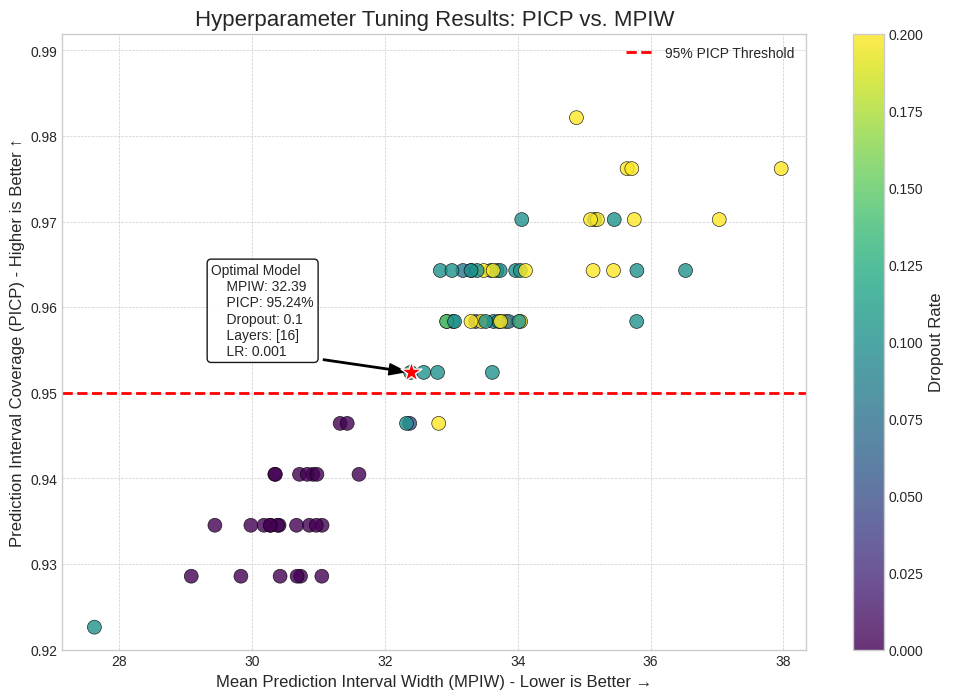

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset from the CSV file you provided
try:
    df = pd.read_csv('all_results.csv')
except FileNotFoundError:
    print("Error: 'all_results.csv' not found. Please ensure the file is in the correct directory.")
    # Create a dummy dataframe if file not found, so the rest of the code can run for demonstration
    df = pd.DataFrame({
        'MPIW': np.random.uniform(30, 40, 50),
        'PICP': np.random.uniform(0.9, 1.0, 50),
        'dropout': np.random.choice([0.0, 0.1, 0.2], 50),
        'layers': ['[16]'] * 50,
        'lr': [0.0005] * 50,
        'batch_size': [16] * 50,
    })


# --- Data Preparation for Plotting ---
# Filter out failed runs to make the plot cleaner and focus on the competitive models
df_filtered = df[df['PICP'] > 0.90].copy()

# Find the optimal model based on your criteria (PICP >= 0.95, then lowest MPIW)
valid_models = df_filtered[df_filtered['PICP'] >= 0.95]
if not valid_models.empty:
    optimal_model = valid_models.loc[valid_models['MPIW'].idxmin()]
else:
    optimal_model = None

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Create the scatter plot, with color representing the dropout rate
scatter = ax.scatter(
    df_filtered['MPIW'],
    df_filtered['PICP'],
    c=df_filtered['dropout'],
    cmap='viridis',
    alpha=0.8,
    s=100, # s is the marker size
    edgecolor='k',
    linewidth=0.5
)

# Add a horizontal line for the 95% PICP threshold
ax.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% PICP Threshold')

# Annotate the optimal point
if optimal_model is not None:
    ax.scatter(optimal_model['MPIW'], optimal_model['PICP'], color='red', s=250, edgecolor='white', marker='*', zorder=5)
    model_text = f"""Optimal Model
    MPIW: {optimal_model['MPIW']:.2f}
    PICP: {optimal_model['PICP']*100:.2f}%
    Dropout: {optimal_model['dropout']}
    Layers: {optimal_model['layers']}
    LR: {optimal_model['lr']}"""
    ax.annotate(
        model_text,
        xy=(optimal_model['MPIW'], optimal_model['PICP']),
        xytext=(optimal_model['MPIW'] - 3, optimal_model['PICP'] + 0.002),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.9)
    )

# --- Formatting ---
ax.set_title('Hyperparameter Tuning Results: PICP vs. MPIW', fontsize=16)
ax.set_xlabel('Mean Prediction Interval Width (MPIW) - Lower is Better →', fontsize=12)
ax.set_ylabel('Prediction Interval Coverage (PICP) - Higher is Better ↑', fontsize=12)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a color bar to explain the dropout colors
cbar = plt.colorbar(scatter)
cbar.set_label('Dropout Rate', fontsize=12)

# Set plot limits for better visualization
plt.ylim(0.92, max(df_filtered['PICP']) * 1.01 if not df_filtered.empty else 1.0)
plt.xlim(min(df_filtered['MPIW']) * 0.99 if not df_filtered.empty else 28, max(df_filtered['MPIW']) * 1.01 if not df_filtered.empty else 36)

# You can also display it directly if you are in a Jupyter Notebook

plt.show()

In [34]:
all_results_df.to_markdown('results.md')